In [2]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py 
import json
import copy
from collections import OrderedDict
from lmfit import Model
import os
from scipy import stats

from pygama.pargen.dsp_optimize import run_one_dsp
from pygama.pargen.dsp_optimize import run_grid
from pygama.pargen.dsp_optimize import ParGrid
from pygama.lgdo.lh5_store import LH5Store
import pygama.math.histogram as pgh
import pygama.math.peak_fitting as pgf
from pygama import __version__ as pygama_version
import pygama
import pygama.lgdo as lgdo
import pygama.lgdo.lh5_store as lh5


sys.path.insert(1, '../analysis/')
import processes.foundation as fd
import processes.fitModel as fM
import processes.histogramAction as hA

import scipy.signal as sig

TypeError: 'list' object is not callable

In [22]:
cwd = os.getcwd()
file = cwd + '/address.json'
with open(file, 'r') as read_file:
    data = json.load(read_file)

runs = list(np.arange(1397,1407,1))


rise = int(5*1000/8)
flat = int(0.5*1000/8)

trapFilter = np.zeros(2*rise + flat)

trapFilter[0:rise] = 1.0
trapFilter[rise+1:flat+rise] = 0.0
trapFilter[rise+flat+1:] = -1.0

t1_data = fd.get_t1_data(1396, "Card1")


trapWave = np.zeros((len(t1_data[0]["waveform"]["values"].nda), len(t1_data[0]["waveform"]["values"].nda[0])- len(trapFilter)+1))
for i,wave in enumerate(t1_data[0]["waveform"]["values"].nda):
    trapWave[i] = sig.convolve(wave, trapFilter, "valid")
    trapWave[i] = trapWave[i]/len(trapFilter)





for i,run in enumerate(runs):
    print(run)
    try:
        t1_data = fd.get_t1_data(run, "Card1")



        hold = np.zeros((len(t1_data[0]["waveform"]["values"].nda), len(t1_data[0]["waveform"]["values"].nda[0])- len(trapFilter)+1))
        for i,wave in enumerate(t1_data[0]["waveform"]["values"].nda):
            hold[i] = sig.convolve(wave, trapFilter, "valid")
            hold[i] = hold[i]/(len(trapFilter))

        trapWave = np.concatenate(trapWave,hold)
    except:
        continue

1397
1398
1399
1400
1401
1402
1403
1404
1405
1406


In [23]:
trapEmax = np.zeros(len(trapWave))
for i,wave in enumerate(trapWave):
    wave = wave - np.mean(wave[0:10000])
    trapEmax[i] = max(wave)

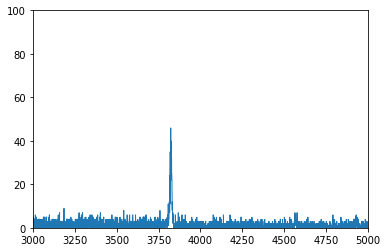

In [20]:
plt.hist(trapEmax, histtype="step",bins=60000)
plt.xlim(3000,5000)
plt.ylim(0,100)
#plt.yscale("log")
plt.show()

0.09014975075925065
-0.38570333596453565


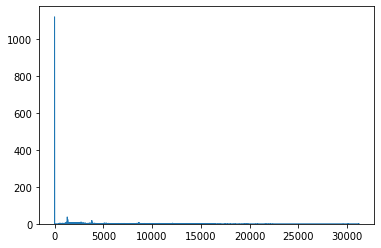

In [21]:
peaks = [[1320, 1400], [2600,3000], [3500,4200]]


energy = [121.78, 244.70, 344.28]

counts, bins, bars = plt.hist(trapEmax, histtype='step', bins=160000)

adc=[]
for range in peaks:
        peak_range = hA.find_nearest_bin(bins, range[0]), hA.find_nearest_bin(bins, range[1])
        peak_idx = np.argmax(counts[peak_range[0]:peak_range[1]]) + peak_range[0]
        peak = bins[peak_idx]
        adc.append(peak)



slope, intercept, r_value, p_value, std_err = stats.linregress(adc,energy)


print(slope)
print(intercept)

In [32]:
m = 0.09014975075925065
c = -0.38570333596453565
energy = [m*x+c for x in trapEmax]

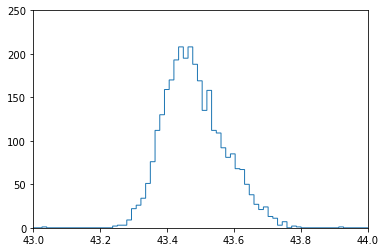

In [28]:
plt.hist(energy, histtype="step", bins=200000)
plt.xlim(43,44)
plt.ylim(0, 250)
plt.show()

0.1508358393519507
0.1624669687352019
0.0013091561336284986


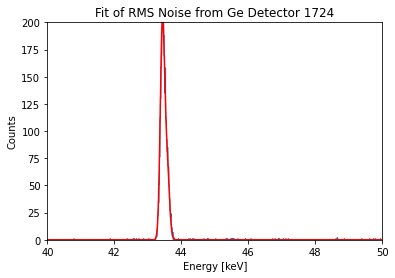

In [33]:
counts, bins, bars = plt.hist(energy, histtype='step', bins=200000)

lower = hA.find_nearest_bin(bins,30)
upper = hA.find_nearest_bin(bins,50)
ydata = counts[lower:upper]
xdata = bins[lower:upper]


    
#gmodel = Model(fM.linDubGaus)
gmodel = Model(fM.linDubGaus)
i = np.argmax(ydata)
#params = gmodel.make_params(A=700, m1=315.5, s1=0.5, H_tail=-0.000001, H_step=1, tau=-0.5, slope=-6, intrcpt=180)
params = gmodel.make_params(a1=400, m1=xdata[i], s1=0.07, a2=400, m2=xdata[i]+0.15, s2=0.07, slope=-0.046, intrcpt=58)
#params['s1'].vary = False
result = gmodel.fit(ydata,params, x=xdata)

sigma1 = result.params['s1'].value
fw1 = 2.355*sigma1
err = result.params['s1'].stderr
err1 = err*2.355
sigma2 = result.params['s2'].value
fw2 = 2.355*sigma2
energy = result.params['m1'].value
print(fw1)
print(fw2)
print(err1)


plt.xlim(40, 50)
plt.ylim(0, 200)
plt.xlabel("Energy [keV]")
plt.ylabel("Counts")
plt.plot(xdata, result.best_fit, 'r-', label='best fit')
#plt.text(42,100, "FWHM = 0.0776(5) keV")
plt.title("Fit of RMS Noise from Ge Detector 1724")
plt.show()


In [ ]:
fw = [0.09399584143811916, ]
rise = [5.0, ]
flat = [0.5, ]
err = [0.00090855841966558, ]

In [2]:
cwd = os.getcwd()
file = cwd + '/address.json'
with open(file, 'r') as read_file:
    data = json.load(read_file)

file = data["tier1_dir"] + "/opt"
optSto = LH5Store(file)
tb_wfs, nwfs = optSto.read_object('Card1/',"Run19.lh5")



In [6]:
rise_arr = np.linspace(5,150,10)
flat_arr = np.linspace(0.8,0.8,1)

fw = np.zeros(len(rise_arr))
err = np.zeros(len(rise_arr))
flats = np.ones(len(rise_arr))*0.8
flat = int(0.8*1000/8)

for i, rise in enumerate(rise_arr):


    rise = int(rise*1000/8)
    flat = int(0.5*1000/8)

    trapFilter = np.zeros(2*rise + flat)

    trapFilter[0:rise] = 1.0
    trapFilter[rise+1:flat+rise] = 0.0
    trapFilter[rise+flat+1:] = -1.0


    trapWave = np.zeros((len(tb_wfs["waveform"]["values"].nda), len(tb_wfs["waveform"]["values"].nda[0])- len(trapFilter)+1))
    for j,wave in enumerate(tb_wfs["waveform"]["values"].nda):
        trapWave[j] = sig.convolve(wave, trapFilter, "valid")


    trapEmax = np.zeros(len(trapWave))
    for j,wave in enumerate(trapWave):
        wave = wave - np.mean(wave[0:10000])
        trapEmax[j] = max(wave)

    m = 4.28206127617879e-05
    c = 0.13105995804698978
    energy = [m*x+c for x in trapEmax]

    binning = np.linspace(30,50,num=30000)
    
    energy
    #counts, bins, bars = plt.hist(energy, histtype='step', bins=100000)
    counts, bins = np.histogram(energy,bins=binning)

    lower = hA.find_nearest_bin(bins,30)
    upper = hA.find_nearest_bin(bins,50)
    ydata = counts[lower:upper]
    xdata = bins[lower:upper]


    
    #gmodel = Model(fM.linDubGaus)
    gmodel = Model(fM.linDubGaus)
    n = np.argmax(ydata)
    #params = gmodel.make_params(A=700, m1=315.5, s1=0.5, H_tail=-0.000001, H_step=1, tau=-0.5, slope=-6, intrcpt=180)
    params = gmodel.make_params(a1=400, m1=xdata[n], s1=0.07, a2=400, m2=xdata[i]+0.15, s2=0.07, slope=-0.046, intrcpt=58)
    #params['s1'].vary = False
    result = gmodel.fit(ydata,params, x=xdata)

    sigma1 = result.params['s1'].value
    fw1 = 2.355*sigma1
    err = result.params['s1'].stderr
    err1 = err*2.355
    sigma2 = result.params['s2'].value
    fw2 = 2.355*sigma2
    energy = result.params['m1'].value
    print(fw1)
    print(fw2)

    fw[i] = fw1
    err[i] = err1


df = pd.DataFrame({"FWHM": fw, "rise": rise_arr, "flat": flats, "error": err})
df.to_csv("RiseNoiseChange1725scipyTrap.csv")



    

-0.00022225419264472866
1.1377392536230588


TypeError: 'numpy.float64' object does not support item assignment